Requerimientos
TensorFlow
https://www.tensorflow.org/install/

Plotly
conda install -c plotly plotly

cufflinks
conda install -c conda-forge cufflinks-py

In [19]:
'''Este ejemplo demuestra el uso de una CNN para la clasificación de texto.
'''
from __future__ import print_function
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

# parametros:
max_features = 16000
maxlen = 33
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 5

In [2]:
#si usamos colab
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [64]:
import pandas as pd
print('Cargando datos...')
data = pd.read_csv('/content/gdrive/MyDrive/Meia2023/Modulo2-ClasificacionTextos/corpusTASS-2020/train.tsv', sep='\t')
data_dev = pd.read_csv('/content/gdrive/MyDrive/Meia2023/Modulo2-ClasificacionTextos/corpusTASS-2020/dev.tsv', sep='\t')

# Diccionario de mapeo de etiquetas
mapeo_etiquetas = {'N': 0, 'NEU': 1, 'P': 2}

# Transformación de la columna "etiqueta"
data['etiqueta_num'] = data['etiqueta'].map(mapeo_etiquetas)
data_dev['etiqueta_num'] = data_dev['etiqueta'].map(mapeo_etiquetas)

x_train, y_train = data['texto'], data['etiqueta_num']
x_test, y_test =data_dev['texto'], data_dev['etiqueta_num']

print(len(x_train), 'ejemplos de entrenamiento')
print(len(x_test), 'ejemplos de prueba')

Cargando datos...
4802 ejemplos de entrenamiento
2443 ejemplos de prueba


In [6]:
set(y_test)

{0, 1, 2}

In [65]:
# Tokenizar los textos
print('train0',x_train[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Obtener la longitud máxima de secuencia
max_sequence_length = max(len(sequence) for sequence in train_sequences)

# Rellenar las secuencias para que todas tengan la misma longitud
x_train = sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
x_test = sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)
print('train0',x_train[0])
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

train0 @morbosaborealis jajajaja... eso es verdad... aquí no hay uno cuerdo 
train0 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 4562  176   44   10  122
  146    4   46  102 4563]
x_train shape: (4802, 33)
x_test shape: (2443, 33)
y_train shape: (4802,)
y_test shape: (2443,)


In [66]:
y_train = np.array([y_train[x] for x in range(len(y_train))]);
y_test = np.array([y_test[x] for x in range(len(y_test))]);

In [43]:
y_train[:10]

array([0, 1, 1, 2, 2, 2, 0, 1, 2, 2])

In [44]:
y_test[:10]

array([0, 1, 0, 1, 0, 0, 0, 1, 2, 0])

In [67]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [72]:
y_train[:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [68]:
print('Construcción del modelo...')
model = Sequential()

# comenzamos con una capa de embeddings eficiente que mapea
# nuestros índices de vocabulario en dimensiones de embedding_dims
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# Agregamos una Convolucion de 1D, que aprenderá filtros.
# de grupo de palabras de tamaño filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# utilizamos max pooling:
model.add(GlobalMaxPooling1D())

# Añadimos una capa oculta vainilla (neurona tradicional) :
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# Proyectamos en una capa de salida de una sola unidad y la aplanamos con un sigmoide:
model.add(Dense(3, activation='softmax'))
#model.add(Activation('softmax'))

print("modelo construido")
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png')

Construcción del modelo...
modelo construido


In [69]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 33, 50)            800000    
                                                                 
 dropout_13 (Dropout)        (None, 33, 50)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 31, 250)           37750     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 250)               62750     
                                                                 
 dropout_14 (Dropout)        (None, 250)               0         
                                                      

In [70]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
model.save_weights('cnn.h5')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


151/151 [==============================] - 9s 60ms/step - loss: 1.0732 - accuracy: 0.4138 - val_loss: 1.0427 - val_accuracy: 0.4515
Epoch 2/5
151/151 [==============================] - 8s 56ms/step - loss: 0.8994 - accuracy: 0.5731 - val_loss: 0.9452 - val_accuracy: 0.5391
Epoch 3/5
151/151 [==============================] - 8s 52ms/step - loss: 0.5667 - accuracy: 0.7803 - val_loss: 1.1080 - val_accuracy: 0.5235
Epoch 4/5
151/151 [==============================] - 9s 59ms/step - loss: 0.2264 - accuracy: 0.9271 - val_loss: 1.5237 - val_accuracy: 0.5162
Epoch 5/5
151/151 [==============================] - 10s 69ms/step - loss: 0.0545 - accuracy: 0.9854 - val_loss: 1.8608 - val_accuracy: 0.5199


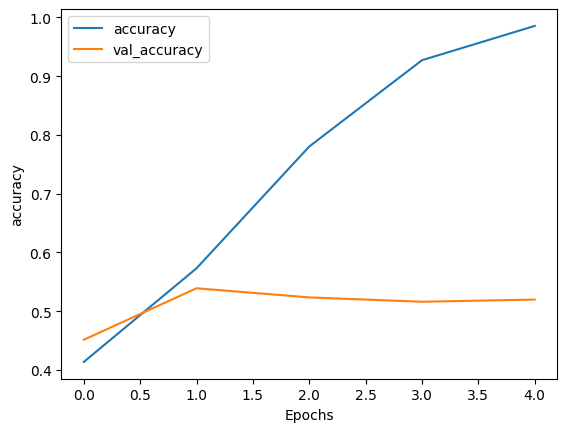

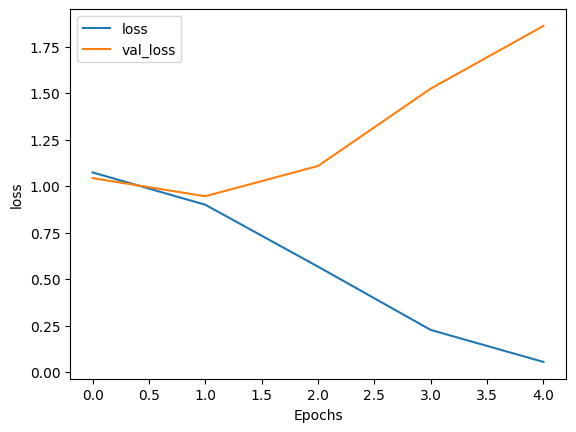

In [71]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")